# 4. Main PD Results

This notebook includes results of our PD models. We run Lasso Logit, Random Forest and Gradient Boosting on Full Data and Clusters for:
* Micro only
* Micro&Macro only

For these models we provide AUC, Confusion Matrix, feature importance and plot Shapley values. Since not all results made the cut to the final report, this is the notbook, where interested reader can find all the details of our PD modelling results.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import warnings
import shap # note it is neccessary to use the 0.44.0 version; the new realise 0.45.0 on 8th of March 2024 is substatially different (i.e. use pip install shap==0.44.0)

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
from utils import get_train_test, load_statistical_clusters, run_model

In [3]:
warnings.filterwarnings('ignore')
plt.style.use('seaborn-whitegrid')


## From now on we use the dataset with imputed missing values

In [4]:
df = pd.read_csv('imputed_MICE_forrest.csv').iloc[:, 1:]

## Merge the imputed dataset with info columns (first 8 columns from the orig dataset)
* note: the number of observations in both df is the same and in the exact same order (in previous steps we only removed columns), so we can concat 1:1 without using any merging key

In [5]:
data = pd.read_pickle('Erasmus_data_stresstesting_2024.pickle').iloc[:, 2:20]

countries_of_interest = ['FI', 'NL', 'AT', 'BE', 'SE', 'DE', 'NO', 'DK', 'IS', 'IT', 'ES', 'PT', 'LV', 'RO', 'HR', 'LT', 'BG', 'SK', 'CZ', 'SI', 'HU', 'PL']

subset_df = data[data['country_code'].isin(countries_of_interest)]

In [6]:
info = subset_df.iloc[:, :7]
info = info.reset_index().iloc[:, 1:]

In [7]:
df = pd.concat([info, df], axis = 1)

## Now we obtain the macro and micro varibales and merge it with our latest df
* note: this time *macros* are merged based on keys: *country code* and *status_year*; WoE_country and WoE_industry on keys: *country_code* and *industry_code*

In [8]:
df2 = pd.read_csv('full_data_woe_rid_-2.csv').iloc[:, 2:]
macro = df2.iloc[:, 61:]

In [9]:
macro = pd.concat([df2[['country_code', 'status_year']], macro], axis = 1)

In [10]:
woe = df2[['country_code', 'industry_code', 'WoE_country', 'WoE_industry']]

In [11]:
macro_uni = macro.drop_duplicates()

In [12]:
woe_uni = woe.drop_duplicates()

In [13]:
df_new = pd.merge(df, woe_uni, on = ['country_code', 'industry_code'])
df_new = pd.merge(df_new, macro_uni, on = ['country_code', 'status_year'])

## Variable *df_new* is the final dataframe with info columns, firm characteristics, WoE columns and macro variables used for PD modelling.

In [14]:
df_new

,country_code,industry_code,size_class,status_year,status_date_latest,status_latest,default_indicator,intangible_fixed_assets_0,intangible_fixed_assets_1,tangible_fixed_assets_0,...,EURxTRY,hh_debt,corp_debt,govt_debt,3m_yield,10y_yield,oil,gas,gold,copper
0,DE,G,SME,2020,16991231,non_default,0,2905.0,9624.000000,65007.0,...,9.07982,57.055937,119.453344,67.986011,-0.425150,-0.511024,32.84,3.4902,1898.36,6352.5562
1,DE,G,SME,2020,16991231,non_default,0,1.0,1.000000,266426.0,...,9.07982,57.055937,119.453344,67.986011,-0.425150,-0.511024,32.84,3.4902,1898.36,6352.5562
2,DE,G,SME,2020,16991231,non_default,0,310.0,0.000000,596041.0,...,9.07982,57.055937,119.453344,67.986011,-0.425150,-0.511024,32.84,3.4902,1898.36,6352.5562
3,DE,G,SME,2020,16991231,non_default,0,3269.0,3714.000000,167798.0,...,9.07982,57.055937,119.453344,67.986011,-0.425150,-0.511024,32.84,3.4902,1898.36,6352.5562
4,DE,G,SME,2020,16991231,non_default,0,68.0,262.000000,1053093.0,...,9.07982,57.055937,119.453344,67.986011,-0.425150,-0.511024,32.84,3.4902,1898.36,6352.5562
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1075921,LV,L,SME,2004,16991231,non_default,0,66871.0,90739.000000,1936418.0,...,1.82091,19.996895,88.332385,13.744445,4.231875,3.875000,234.51,692.6744,438.45,2323.6943
1075922,LV,J,SME,2004,16991231,non_default,0,19037.0,47858.105616,203540.0,...,1.82091,19.996895,88.332385,13.744445,4.231875,3.875000,234.51,692.6744,438.45,2323.6943
1075923,LV,R,SME,2004,16991231,non_default,0,5228.0,47858.105616,2498256.0,...,1.82091,19.996895,88.332385,13.744445,4.231875,3.875000,234.51,692.6744,438.45,2323.6943
1075924,LV,A,SME,2001,16991231,non_default,0,0.0,47858.105616,2271159.0,...,1.29230,7.683075,83.443015,17.459588,6.861667,5.408333,114.44,990.0938,278.95,1678.1713


# Results for FULL DATA (no clustering) -- RF

## MICRO

In [15]:
y = df_new['default_indicator']
X = df_new.iloc[:, 7:60]

In [16]:
X

,intangible_fixed_assets_0,intangible_fixed_assets_1,tangible_fixed_assets_0,tangible_fixed_assets_1,other_fixed_assets_0,other_fixed_assets_1,stock_0,stock_1,debtors_0,debtors_1,...,costs_of_employees_0,costs_of_employees_1,depreciation_amortization_0,depreciation_amortization_1,interest_paid_0,cash_flow_0,cash_flow_1,added_value_0,WoE_country,WoE_industry
0,2905.0,9624.000000,65007.0,8.164000e+04,5000.0,5.000000e+03,891934.0,9.047550e+05,0.0,0.000000e+00,...,1.152769e+06,1.138101e+06,3.960123e+04,7.901240e+04,6.628698e+04,2.195648e+05,4.454673e+05,1.508894e+06,-0.354174,-0.056866
1,1.0,1.000000,266426.0,2.806030e+05,152155.0,0.000000e+00,266255.0,1.777810e+05,0.0,0.000000e+00,...,1.166462e+06,1.138101e+06,6.114279e+04,7.901240e+04,6.628698e+04,2.195648e+05,4.454673e+05,1.508894e+06,-0.354174,-0.056866
2,310.0,0.000000,596041.0,6.018440e+05,0.0,0.000000e+00,490006.0,4.701660e+05,1532.0,2.605000e+03,...,5.087900e+05,4.324650e+05,9.446000e+04,9.398800e+04,3.007000e+03,3.289070e+05,3.694330e+05,9.347450e+05,-0.354174,-0.056866
3,3269.0,3714.000000,167798.0,8.515900e+04,250.0,2.500000e+02,2387122.0,2.094560e+06,0.0,0.000000e+00,...,1.152769e+06,1.138101e+06,4.896299e+04,7.901240e+04,6.628698e+04,2.195648e+05,4.454673e+05,1.508894e+06,-0.354174,-0.056866
4,68.0,262.000000,1053093.0,9.262990e+05,153.0,1.530000e+02,807575.0,1.633121e+06,0.0,0.000000e+00,...,6.348291e+05,5.996513e+05,2.097170e+05,2.048864e+05,6.628698e+04,2.195648e+05,4.454673e+05,6.435161e+05,-0.354174,-0.056866
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1075921,66871.0,90739.000000,1936418.0,1.934787e+06,1423.0,6.000500e+04,1631941.0,1.565978e+06,1809790.0,1.208876e+06,...,1.152769e+06,1.138101e+06,2.163638e+05,2.048864e+05,2.418700e+04,2.195648e+05,4.454673e+05,1.508894e+06,1.082824,0.156895
1075922,19037.0,47858.105616,203540.0,3.214865e+05,295240.0,1.007275e+05,19873.0,2.859826e+05,891122.0,1.032384e+06,...,1.166462e+06,1.138101e+06,6.114279e+04,7.901240e+04,5.021900e+04,2.195648e+05,4.454673e+05,1.508894e+06,1.082824,-0.222518
1075923,5228.0,47858.105616,2498256.0,1.759926e+06,278401.0,1.007275e+05,107248.0,2.859826e+05,737776.0,7.252454e+05,...,1.431550e+06,1.429671e+06,2.097170e+05,2.048864e+05,2.801800e+04,2.195648e+05,4.454673e+05,1.634341e+06,1.082824,0.058225
1075924,0.0,47858.105616,2271159.0,1.759926e+06,103154.0,1.007275e+05,327246.0,2.859826e+05,631371.0,7.252454e+05,...,1.152769e+06,1.138101e+06,2.097170e+05,2.048864e+05,6.224800e+04,2.195648e+05,4.454673e+05,1.508894e+06,1.082824,-0.809423


In [17]:
data = get_train_test(X, y, use_SMOTE=True)

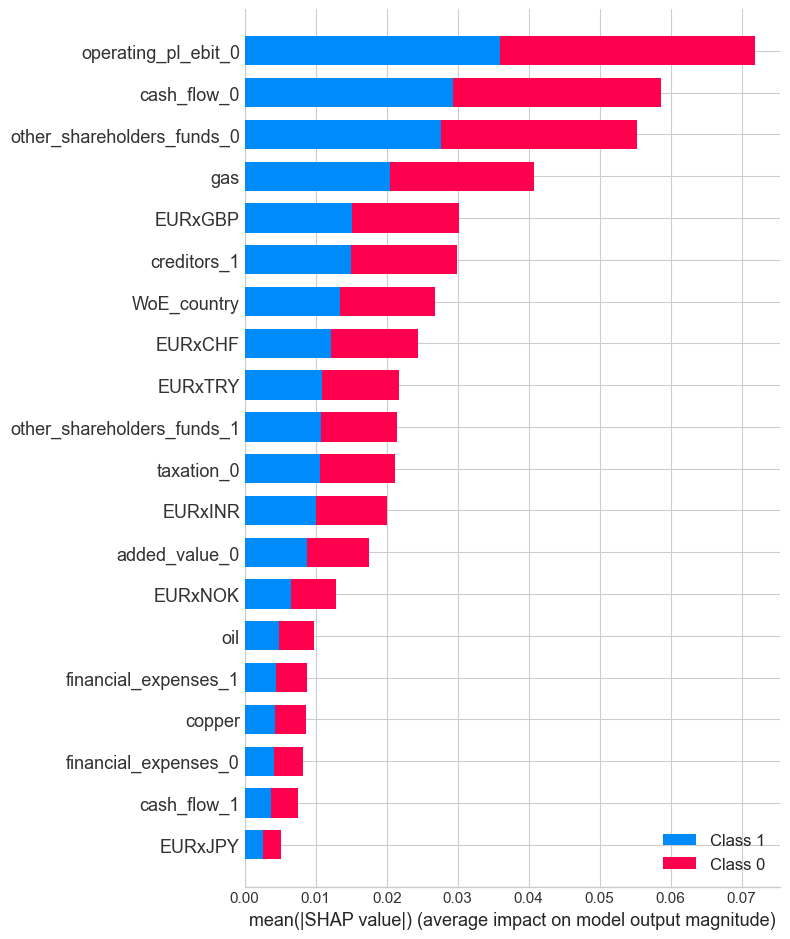

Results for RF
------------------------------
Confussion Matrx:
 [[211148   2690]
 [   886    462]]

AUC: 0.8532

Feature Importance:

The most important features for RF are:
operating_pl_ebit_0 : 0.193
other_shareholders_funds_0 : 0.155
cash_flow_0 : 0.151
added_value_0 : 0.085
EURxCHF : 0.065


In [21]:
m = run_model(data, type = 'RF', n_estimators=50, max_depth=3, SHAP = True, feat_imp = True)

## MICRO + MACRO

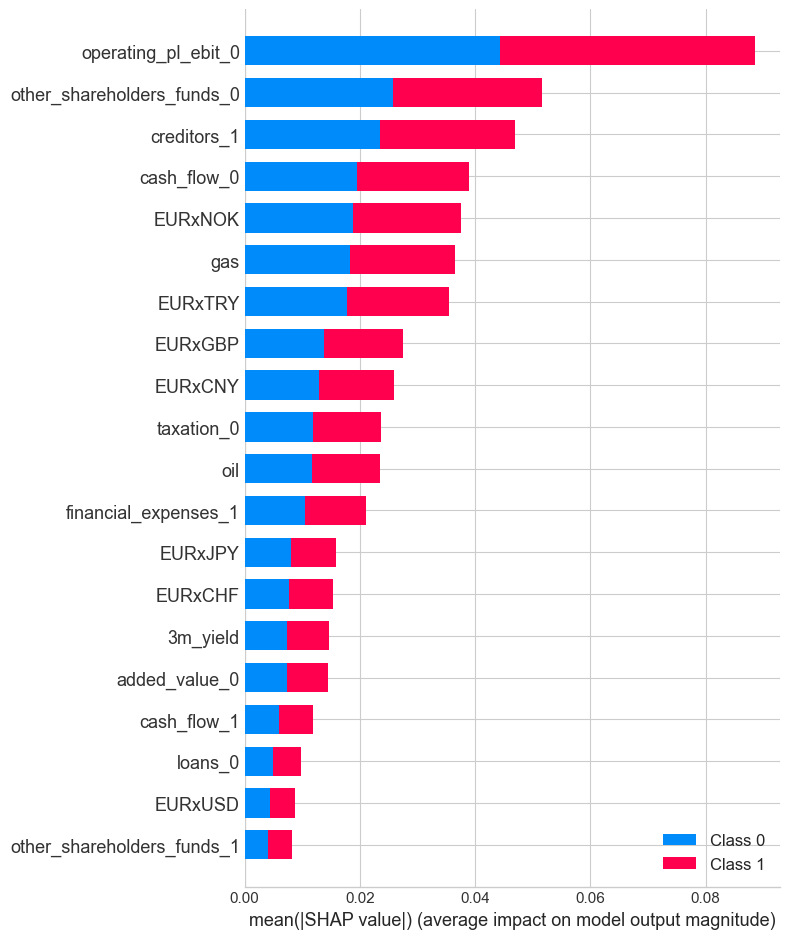

Results for RF
------------------------------
Confussion Matrx:
 [[211618   2220]
 [   939    409]]

AUC: 0.838

Feature Importance:

The most important features for RF are:
operating_pl_ebit_0 : 0.156
other_shareholders_funds_0 : 0.149
cash_flow_0 : 0.136
added_value_0 : 0.065
EURxCHF : 0.043


In [29]:
y = df_new['default_indicator']
X = df_new.iloc[:, 7:]
data = get_train_test(X, y, use_SMOTE=True)
m = run_model(data, type = 'RF', n_estimators=50, max_depth=3, SHAP = True, feat_imp = True)

# Results for CLUSTERS

### Firstly, we create the clusters

In [30]:
clusters = load_statistical_clusters(df_new)
cluster_names = ['SE_SERV', 'SE_COMD', 'SE_INFR', 'EE_INFR', 'EE_StSERV', 'EE_COMD', 'EE_CySERV', 'NE_SERV', 'NE_COMD', 'NE_INFR']

## MICRO

Cluster SE_SERV


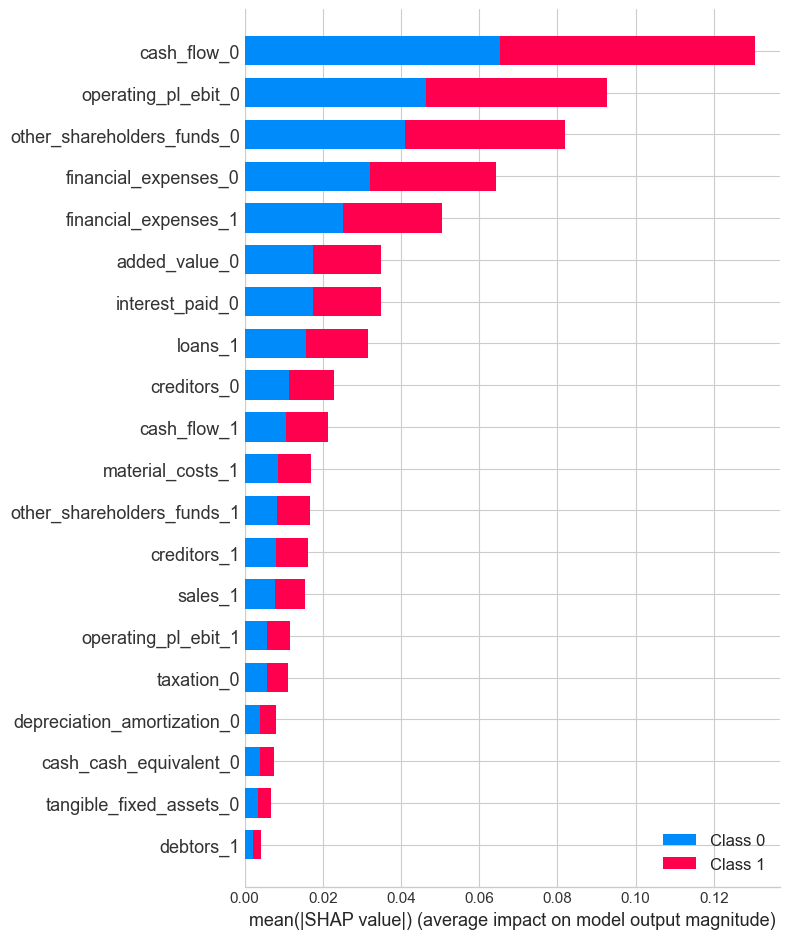

Results for RF
------------------------------
Confussion Matrx:
 [[70479  1870]
 [  221   307]]

AUC: 0.9074

Feature Importance:

The most important features for RF are:
cash_flow_0 : 0.216
other_shareholders_funds_0 : 0.213
operating_pl_ebit_0 : 0.184
added_value_0 : 0.095
financial_expenses_0 : 0.037
Cluster SE_COMD


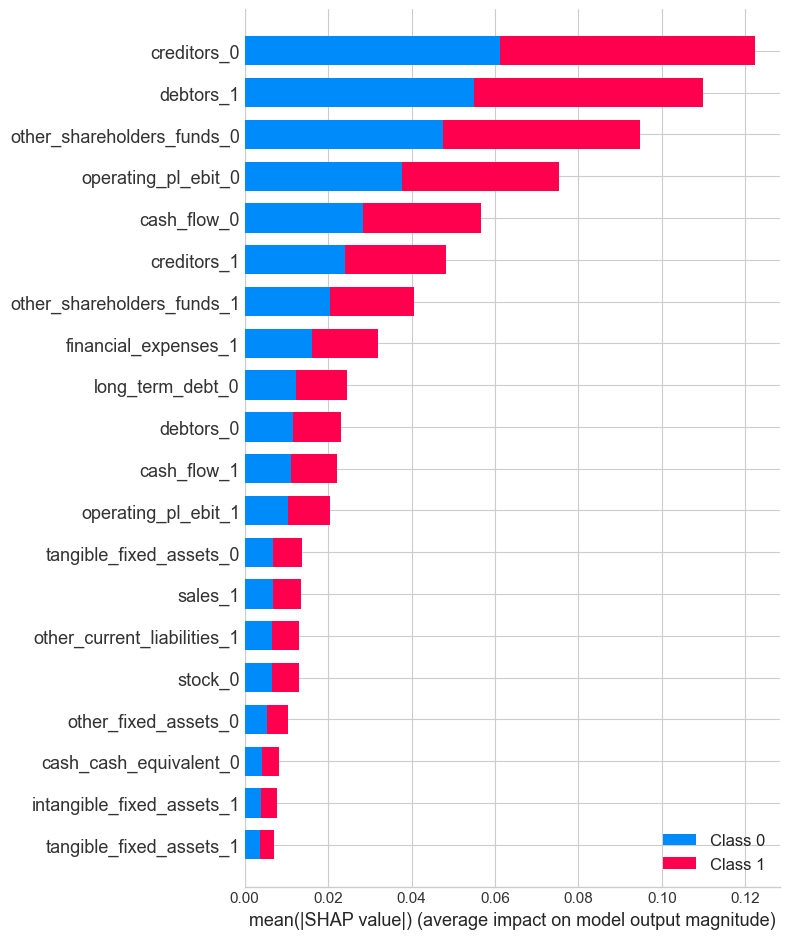

Results for RF
------------------------------
Confussion Matrx:
 [[8948  207]
 [  22   20]]

AUC: 0.8898

Feature Importance:

The most important features for RF are:
other_shareholders_funds_0 : 0.211
cash_flow_0 : 0.181
operating_pl_ebit_0 : 0.173
other_shareholders_funds_1 : 0.064
cash_flow_1 : 0.058
Cluster SE_INFR


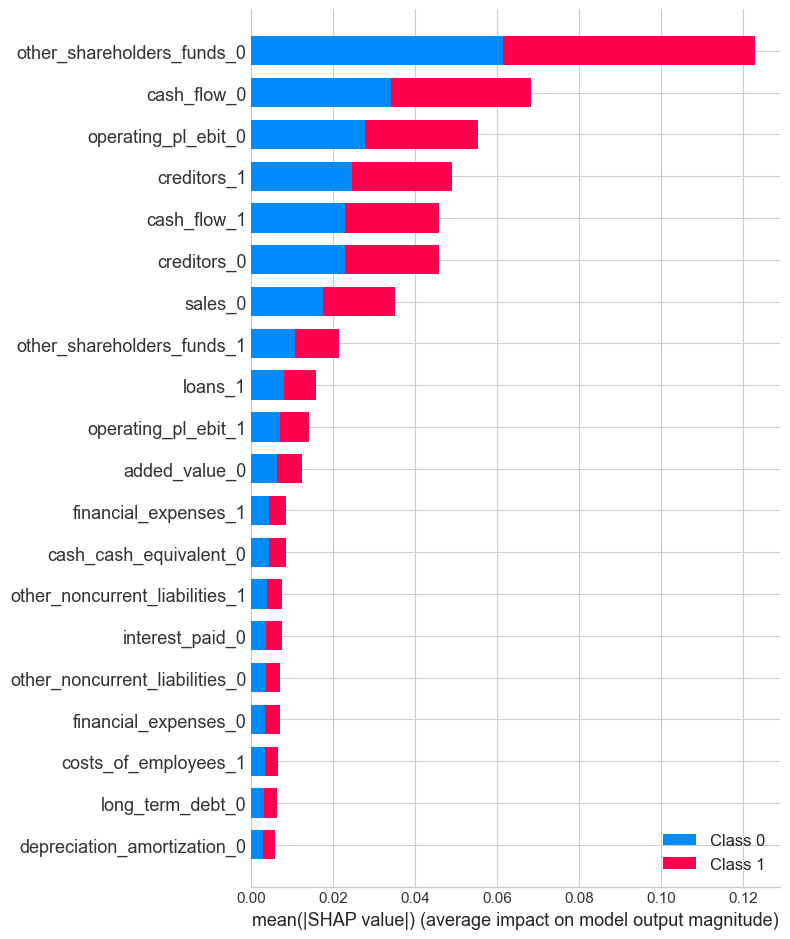

Results for RF
------------------------------
Confussion Matrx:
 [[22748   505]
 [  152   103]]

AUC: 0.8664

Feature Importance:

The most important features for RF are:
other_shareholders_funds_0 : 0.361
cash_flow_0 : 0.15
operating_pl_ebit_0 : 0.113
cash_flow_1 : 0.052
other_shareholders_funds_1 : 0.049
Cluster EE_INFR


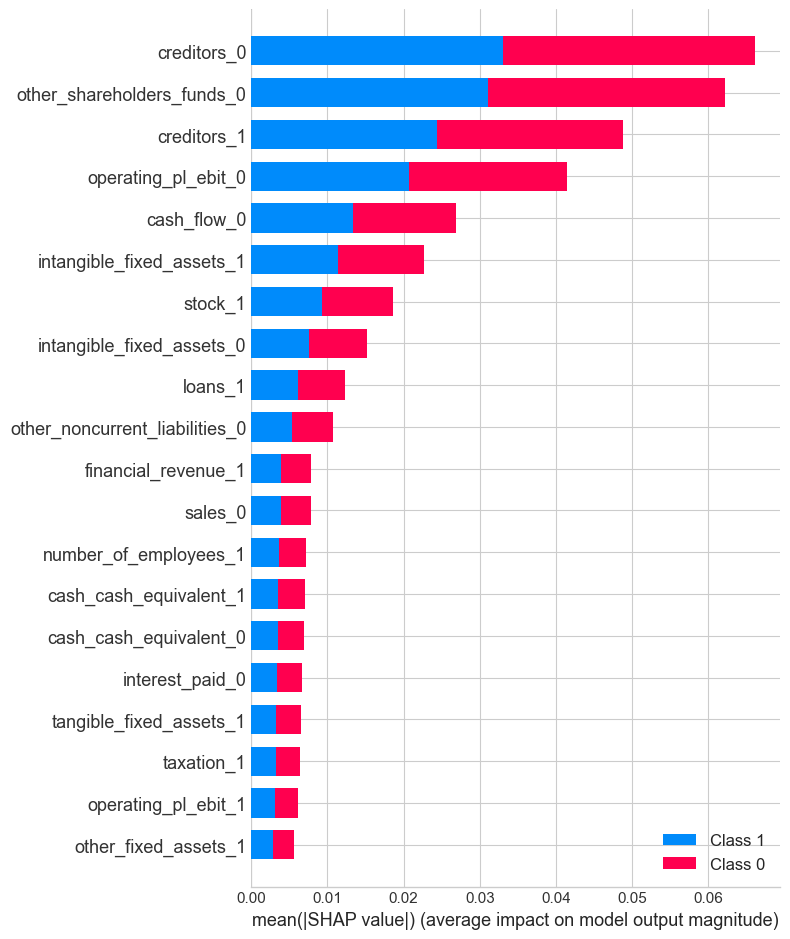

Results for RF
------------------------------
Confussion Matrx:
 [[13282    90]
 [   78     5]]

AUC: 0.7396

Feature Importance:

The most important features for RF are:
other_shareholders_funds_0 : 0.186
operating_pl_ebit_0 : 0.161
intangible_fixed_assets_1 : 0.092
cash_flow_0 : 0.085
loans_1 : 0.065
Cluster EE_StSERV


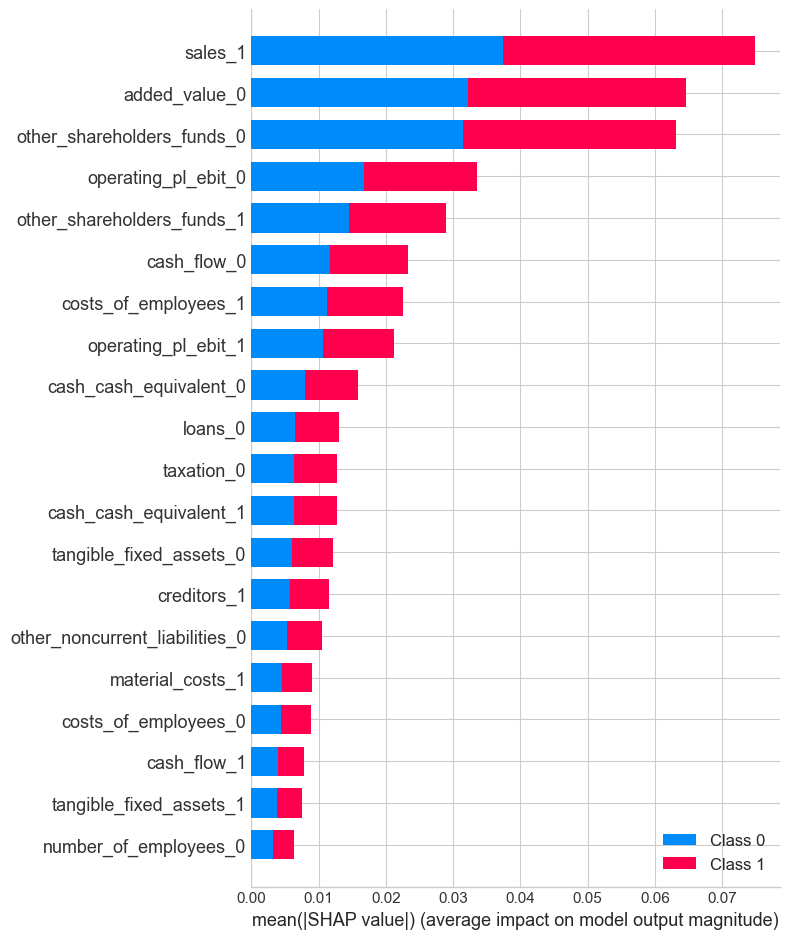

Results for RF
------------------------------
Confussion Matrx:
 [[6408   35]
 [  23    2]]

AUC: 0.7623

Feature Importance:

The most important features for RF are:
other_shareholders_funds_0 : 0.149
added_value_0 : 0.141
operating_pl_ebit_0 : 0.097
sales_1 : 0.061
cash_flow_0 : 0.06
Cluster EE_COMD


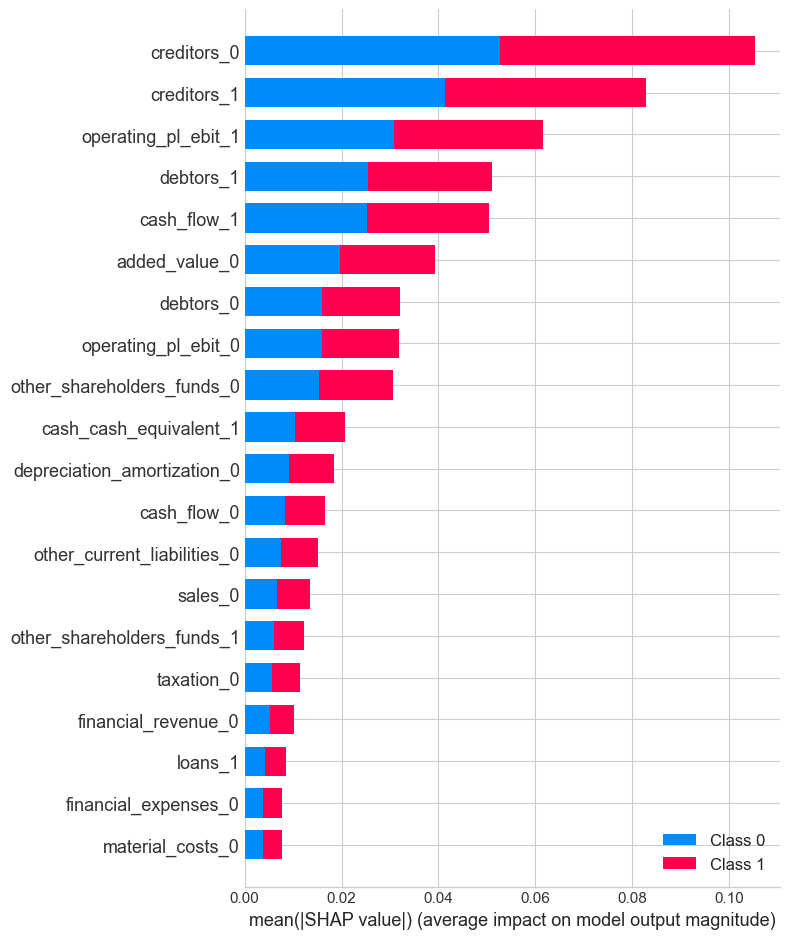

Results for RF
------------------------------
Confussion Matrx:
 [[4488   61]
 [  10    1]]

AUC: 0.7622

Feature Importance:

The most important features for RF are:
cash_flow_1 : 0.112
other_shareholders_funds_0 : 0.103
cash_flow_0 : 0.102
operating_pl_ebit_1 : 0.092
creditors_0 : 0.06
Cluster EE_CySERV


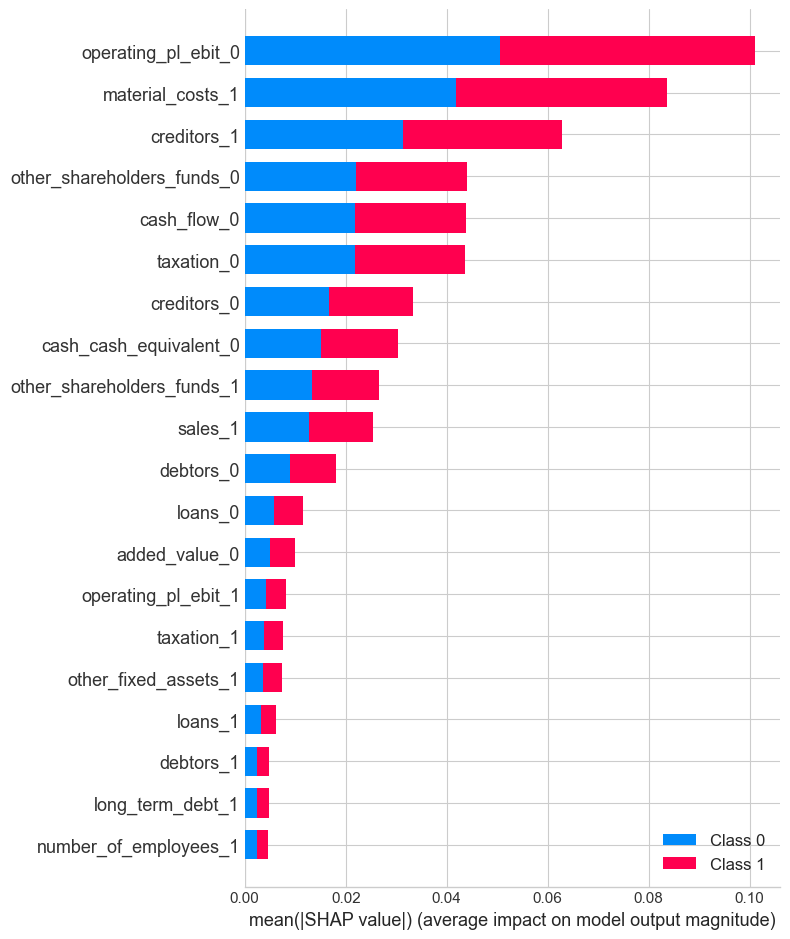

Results for RF
------------------------------
Confussion Matrx:
 [[31617   532]
 [   97    28]]

AUC: 0.7496

Feature Importance:

The most important features for RF are:
operating_pl_ebit_0 : 0.287
cash_flow_0 : 0.147
other_shareholders_funds_0 : 0.129
taxation_0 : 0.071
added_value_0 : 0.054
Cluster NE_SERV


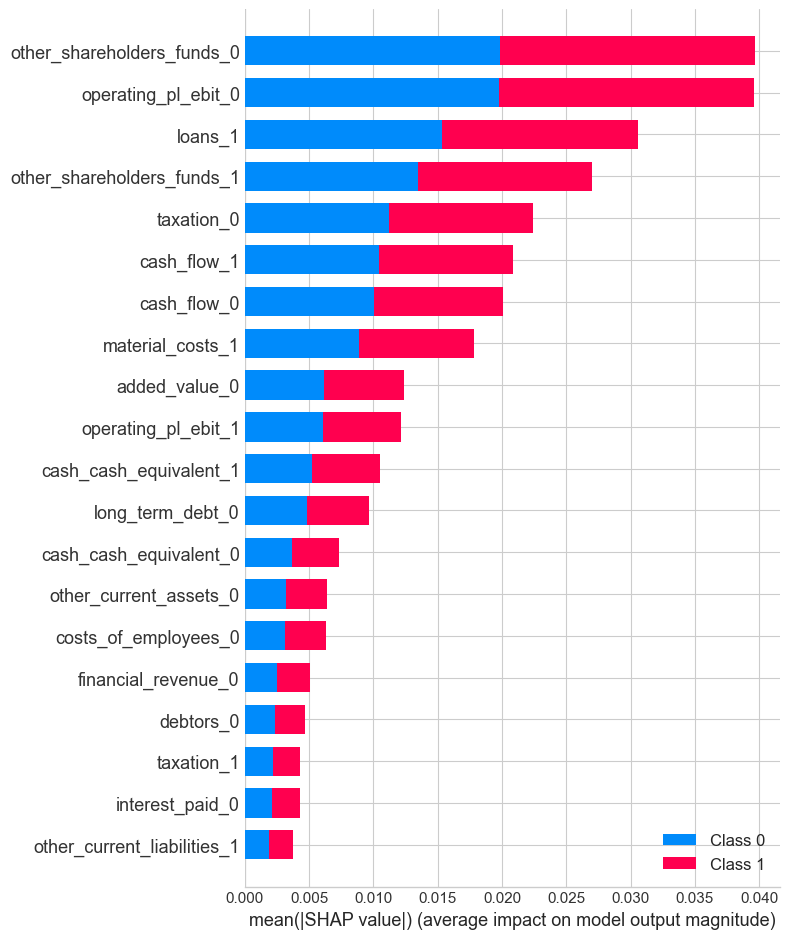

Results for RF
------------------------------
Confussion Matrx:
 [[30521   439]
 [  147    27]]

AUC: 0.7399

Feature Importance:

The most important features for RF are:
cash_flow_0 : 0.174
operating_pl_ebit_0 : 0.151
other_shareholders_funds_0 : 0.127
cash_flow_1 : 0.074
taxation_0 : 0.066
Cluster NE_COMD


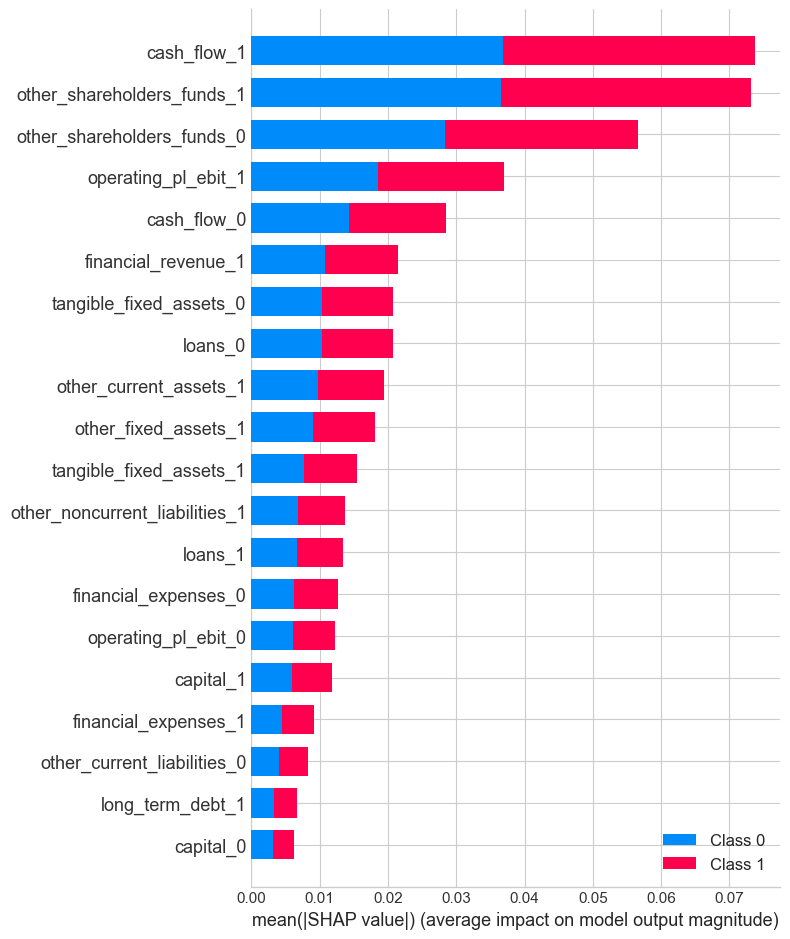

Results for RF
------------------------------
Confussion Matrx:
 [[5182   67]
 [  17    0]]

AUC: 0.564

Feature Importance:

The most important features for RF are:
cash_flow_1 : 0.141
other_shareholders_funds_1 : 0.117
other_shareholders_funds_0 : 0.099
cash_flow_0 : 0.076
operating_pl_ebit_1 : 0.065
Cluster NE_INFR


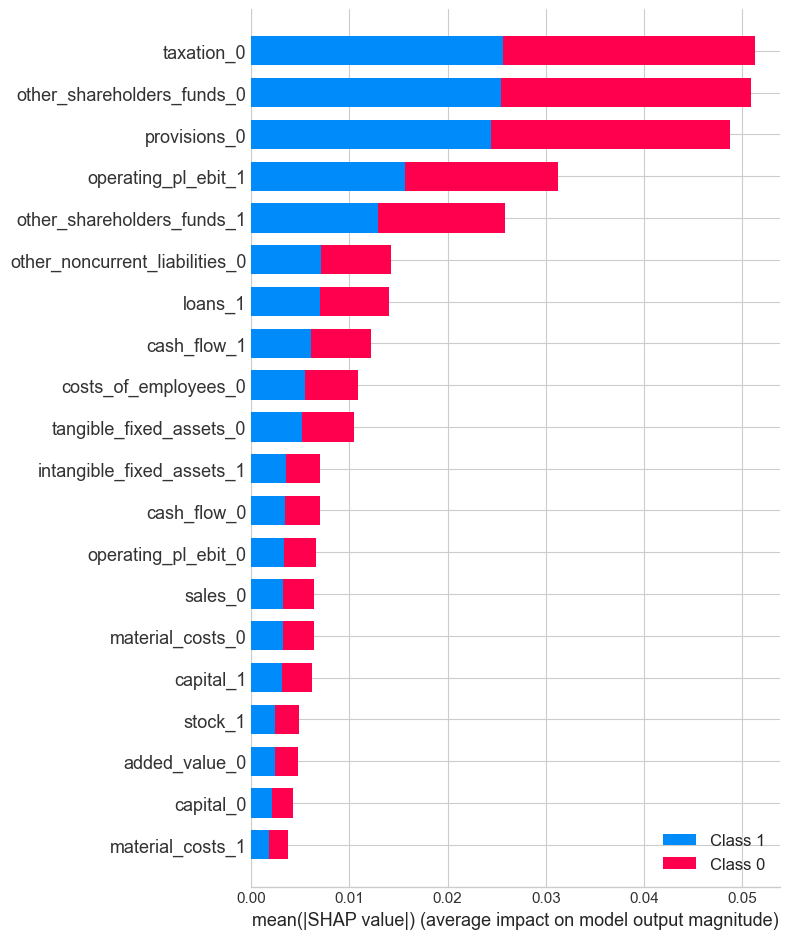

Results for RF
------------------------------
Confussion Matrx:
 [[16284    80]
 [   87     1]]

AUC: 0.7829

Feature Importance:

The most important features for RF are:
other_shareholders_funds_0 : 0.171
cash_flow_0 : 0.11
taxation_0 : 0.103
loans_1 : 0.091
operating_pl_ebit_0 : 0.062


In [31]:
for cluster in range(len(clusters)):
    y = clusters[cluster]['default_indicator']
    X = clusters[cluster].iloc[:, 7:60].drop(['WoE_country', 'WoE_industry'], axis=1)
    data = get_train_test(X, y, use_SMOTE=True)
    print(f'Cluster {cluster_names[cluster]}')
    m = run_model(data, type = 'RF', n_estimators=50, max_depth=3, SHAP = True, feat_imp = True)

## MICRO + MACRO

Cluster SE_SERV


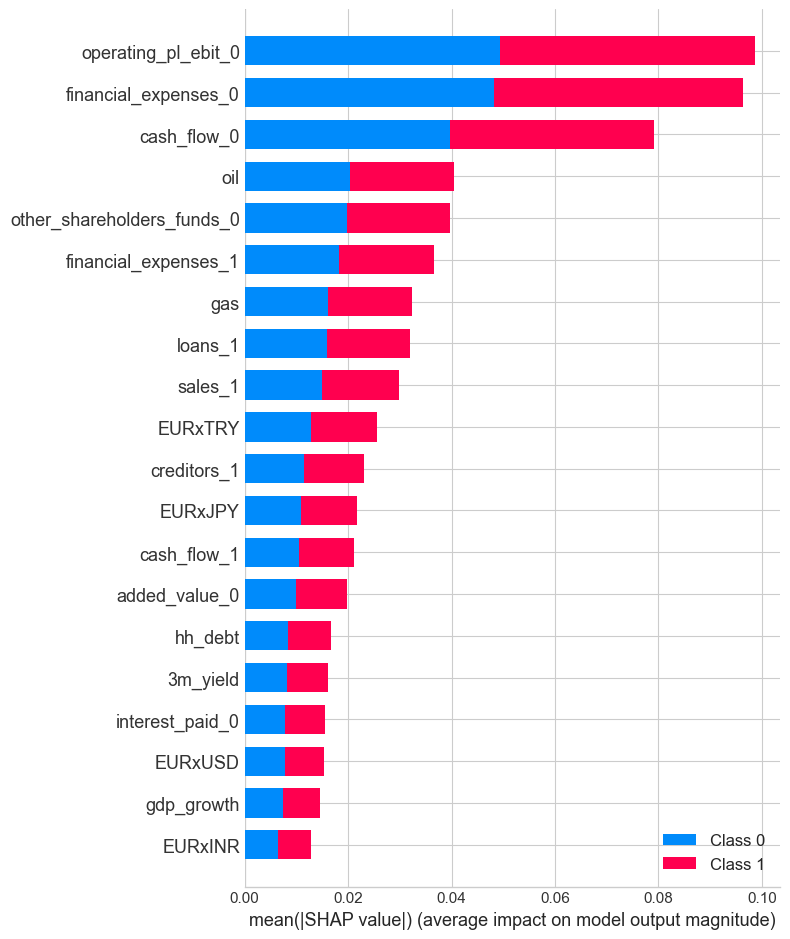

Results for RF
------------------------------
Confussion Matrx:
 [[71232  1117]
 [  258   270]]

AUC: 0.8972

Feature Importance:

The most important features for RF are:
cash_flow_0 : 0.204
operating_pl_ebit_0 : 0.176
other_shareholders_funds_0 : 0.09
added_value_0 : 0.067
cash_flow_1 : 0.063
Cluster SE_COMD


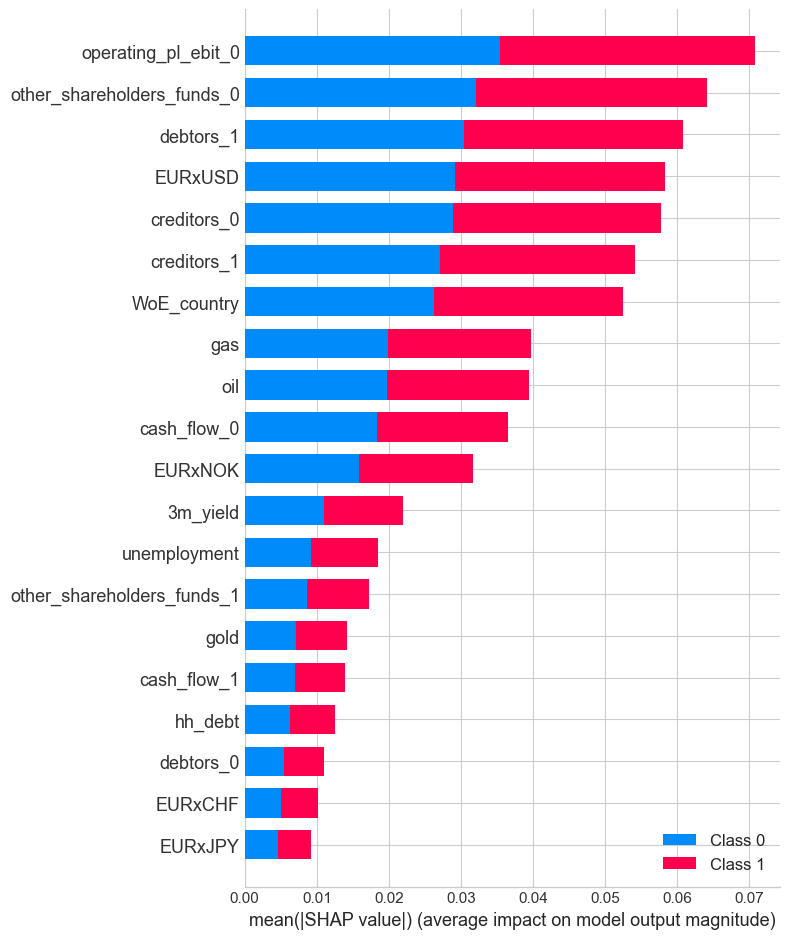

Results for RF
------------------------------
Confussion Matrx:
 [[9005  150]
 [  25   17]]

AUC: 0.8819

Feature Importance:

The most important features for RF are:
other_shareholders_funds_0 : 0.181
operating_pl_ebit_0 : 0.175
cash_flow_0 : 0.119
EURxNOK : 0.062
WoE_country : 0.046
Cluster SE_INFR


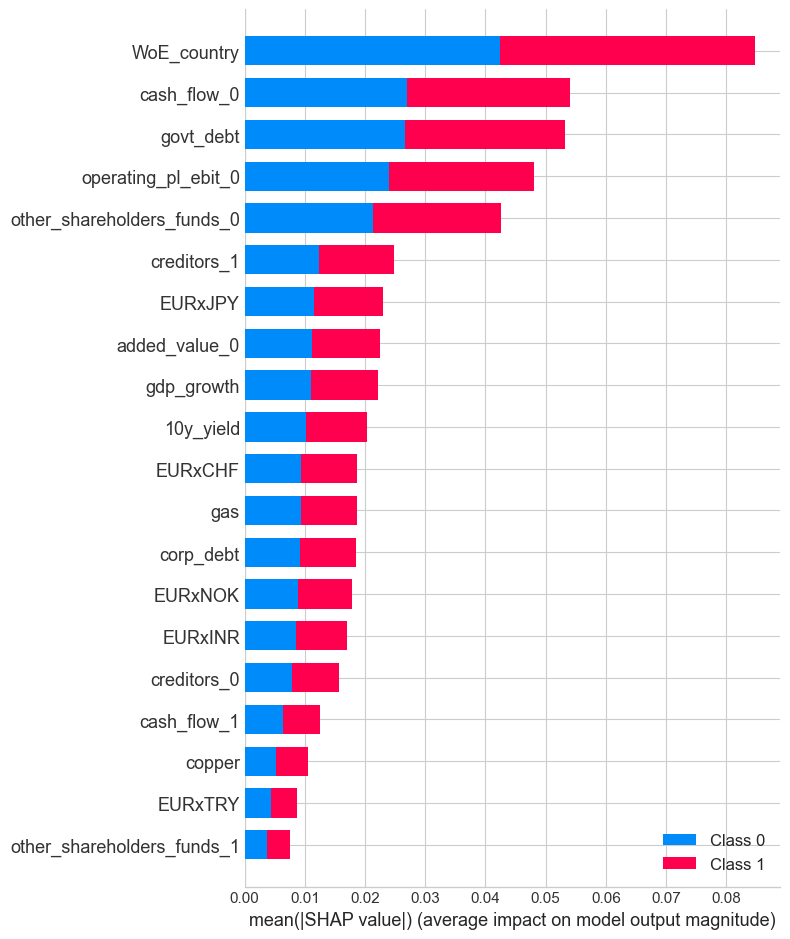

Results for RF
------------------------------
Confussion Matrx:
 [[22992   261]
 [  164    91]]

AUC: 0.8809

Feature Importance:

The most important features for RF are:
cash_flow_0 : 0.187
other_shareholders_funds_0 : 0.131
operating_pl_ebit_0 : 0.118
added_value_0 : 0.083
WoE_country : 0.06
Cluster EE_INFR


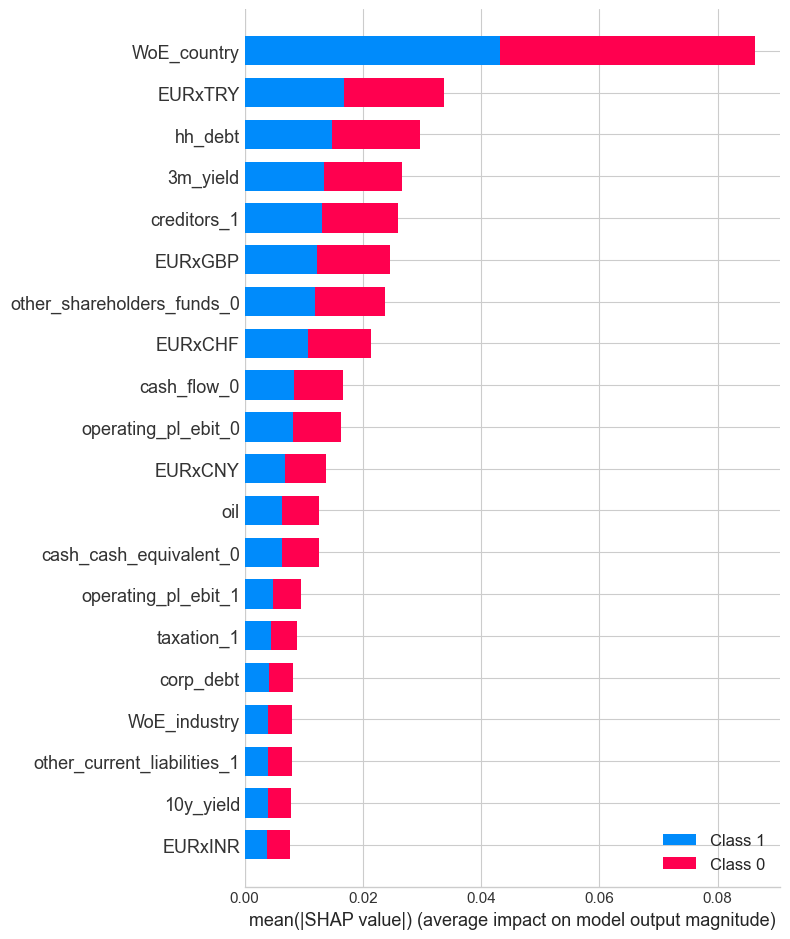

Results for RF
------------------------------
Confussion Matrx:
 [[13346    26]
 [   80     3]]

AUC: 0.774

Feature Importance:

The most important features for RF are:
WoE_country : 0.194
operating_pl_ebit_0 : 0.089
other_shareholders_funds_0 : 0.076
cash_flow_0 : 0.073
hh_debt : 0.072
Cluster EE_StSERV


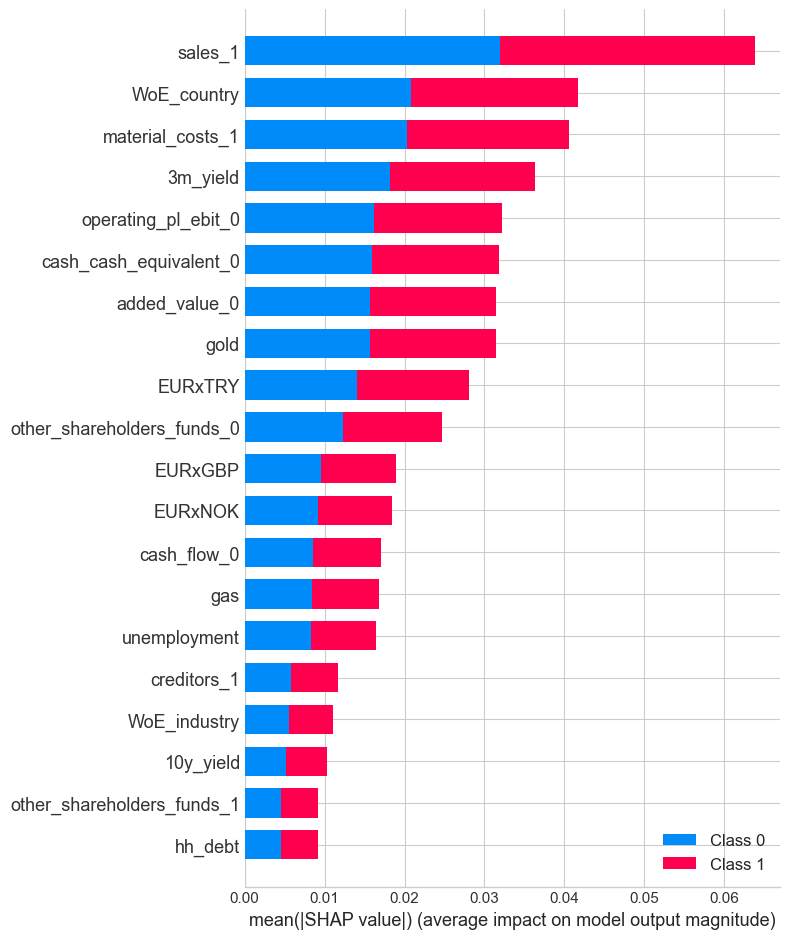

Results for RF
------------------------------
Confussion Matrx:
 [[6427   16]
 [  23    2]]

AUC: 0.8347

Feature Importance:

The most important features for RF are:
WoE_country : 0.139
other_shareholders_funds_0 : 0.106
added_value_0 : 0.082
operating_pl_ebit_0 : 0.07
cash_flow_0 : 0.067
Cluster EE_COMD


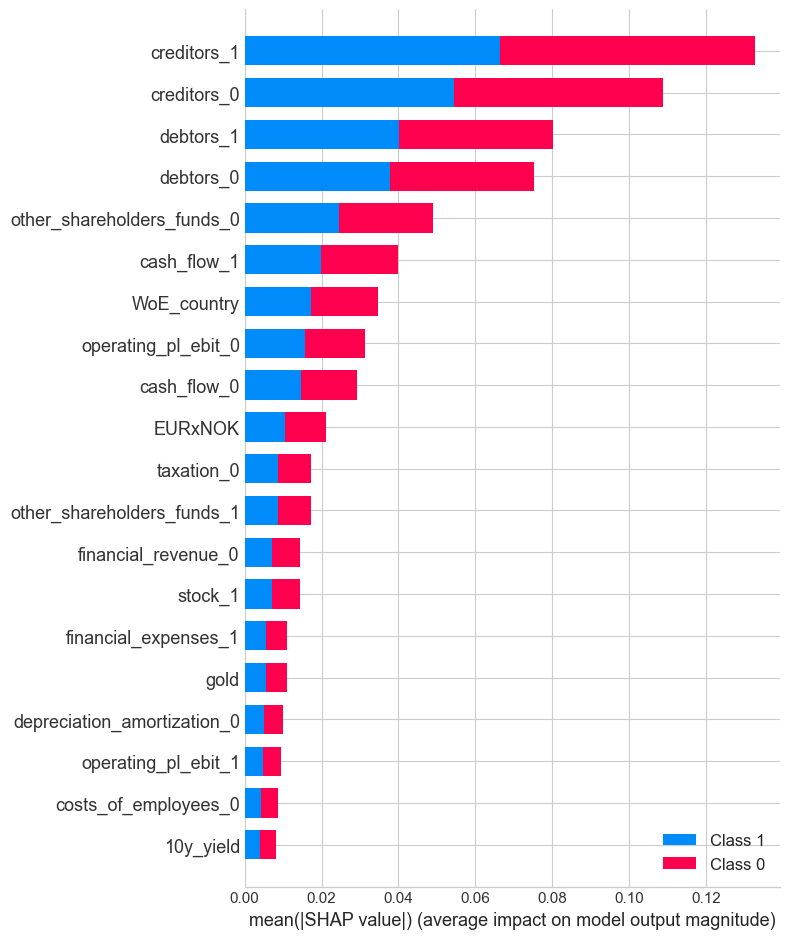

Results for RF
------------------------------
Confussion Matrx:
 [[4503   46]
 [  10    1]]

AUC: 0.7895

Feature Importance:

The most important features for RF are:
cash_flow_0 : 0.118
other_shareholders_funds_0 : 0.108
cash_flow_1 : 0.078
creditors_0 : 0.06
other_shareholders_funds_1 : 0.053
Cluster EE_CySERV


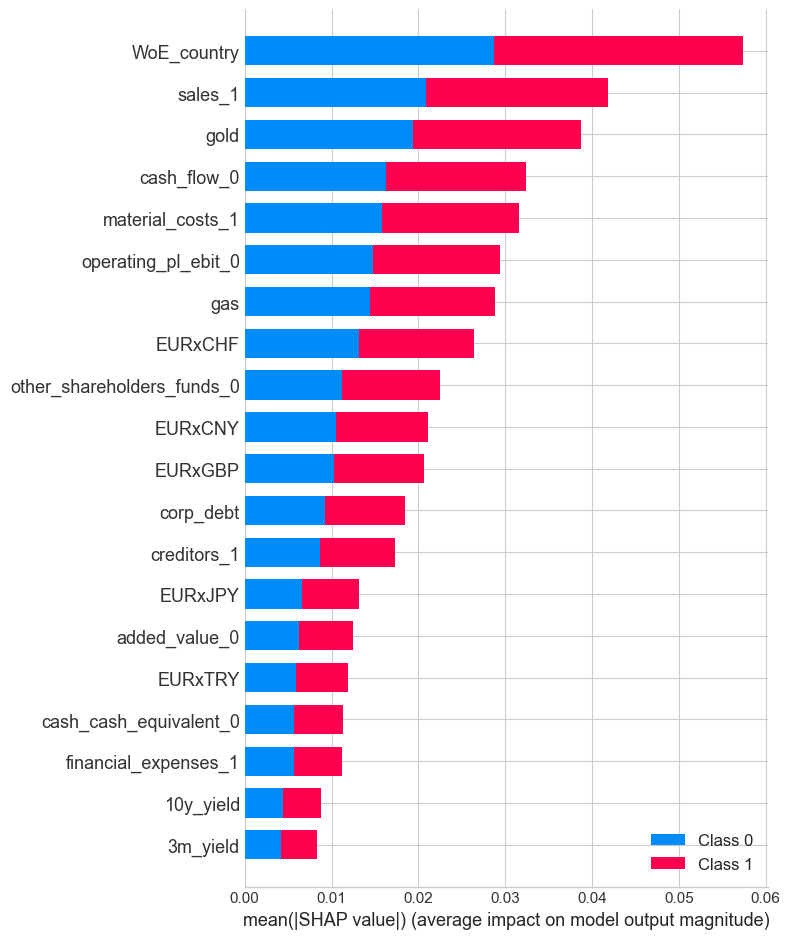

Results for RF
------------------------------
Confussion Matrx:
 [[32053    96]
 [  108    17]]

AUC: 0.7844

Feature Importance:

The most important features for RF are:
WoE_country : 0.168
cash_flow_0 : 0.114
operating_pl_ebit_0 : 0.108
other_shareholders_funds_0 : 0.067
gold : 0.061
Cluster NE_SERV


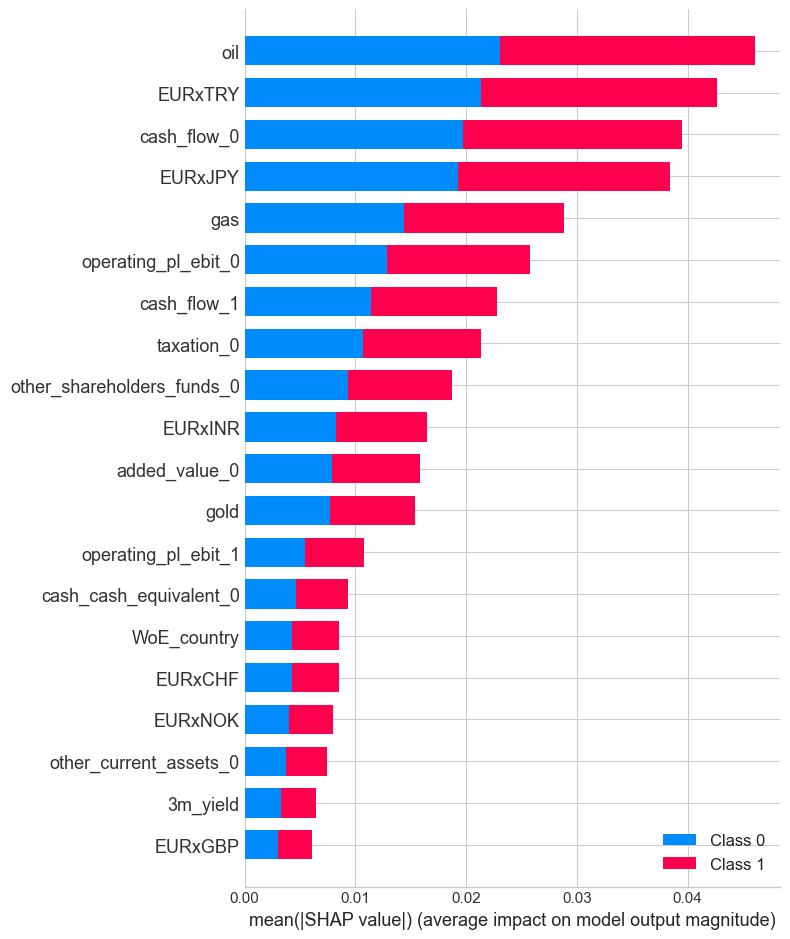

Results for RF
------------------------------
Confussion Matrx:
 [[30828   132]
 [  165     9]]

AUC: 0.7143

Feature Importance:

The most important features for RF are:
cash_flow_0 : 0.12
operating_pl_ebit_0 : 0.096
cash_flow_1 : 0.081
added_value_0 : 0.075
taxation_0 : 0.074
Cluster NE_COMD


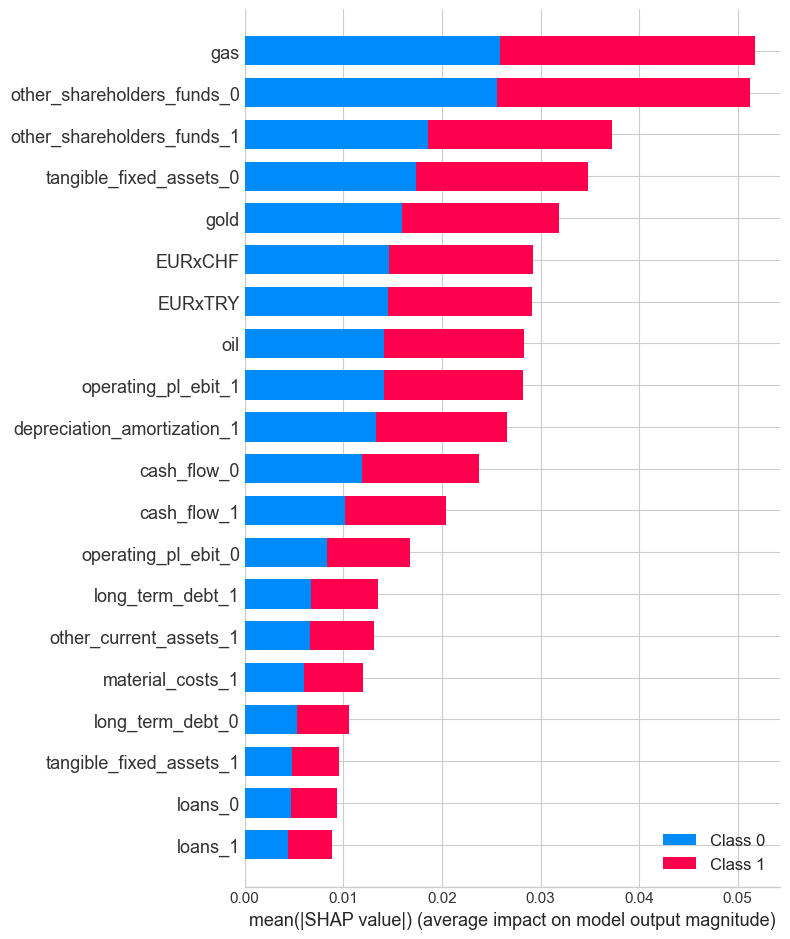

Results for RF
------------------------------
Confussion Matrx:
 [[5203   46]
 [  16    1]]

AUC: 0.6332

Feature Importance:

The most important features for RF are:
other_shareholders_funds_1 : 0.121
other_shareholders_funds_0 : 0.105
operating_pl_ebit_1 : 0.085
cash_flow_0 : 0.061
cash_flow_1 : 0.059
Cluster NE_INFR


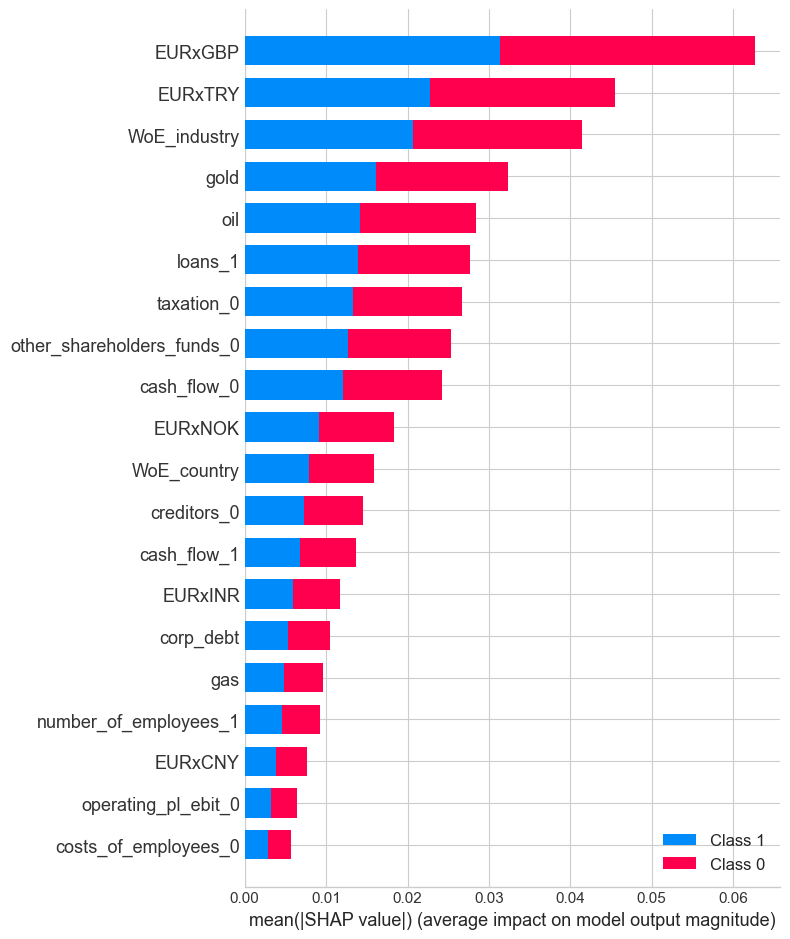

Results for RF
------------------------------
Confussion Matrx:
 [[16363     1]
 [   88     0]]

AUC: 0.7592

Feature Importance:

The most important features for RF are:
cash_flow_0 : 0.102
EURxGBP : 0.078
taxation_0 : 0.067
other_shareholders_funds_0 : 0.066
EURxTRY : 0.061


In [30]:
models = []
for cluster in range(len(clusters)):
    y = clusters[cluster]['default_indicator']
    X = clusters[cluster].iloc[:, 7:].drop(['WoE_country', 'WoE_industry'], axis=1)
    data = get_train_test(X, y, use_SMOTE=True)
    print(f'Cluster {cluster_names[cluster]}')
    models.append(run_model(data, type = 'RF', n_estimators=50, max_depth=3, SHAP = True, feat_imp = True))

## Shapley Values Interpretation

In [25]:
explainer = shap.TreeExplainer(models[0].steps[1][1])
shap_values = explainer(data[0])

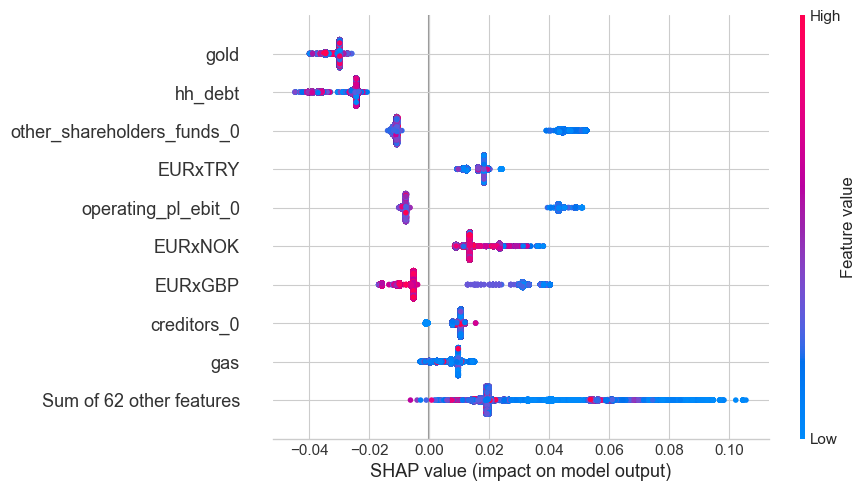

In [ ]:
shap.plots.beeswarm(shap_values[..., 1])

In [ ]:
# run separatedly for each cluste

subset = []
for col in ['gold', 'hh_debt', 'other_shareholders_funds_0']:
    subset.append(data[0].columns.get_loc(col))

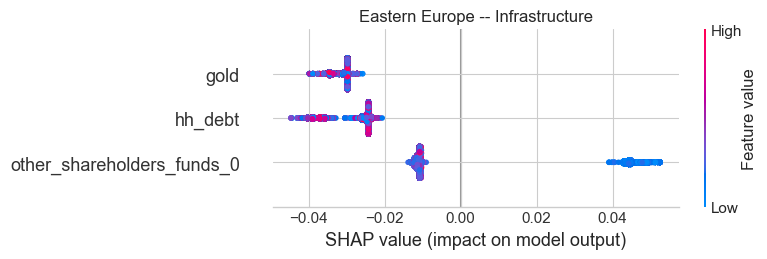

In [ ]:
# save; manually changed the title and file name for each cluster

shap.plots.beeswarm(shap_values[...,subset, 1], show = False)
plt.title('Eastern Europe -- Infrastructure')
plt.tight_layout()
plt.savefig('c4a.png', facecolor = 'white', dpi = 300)



### Besswarm plots for each cluster:

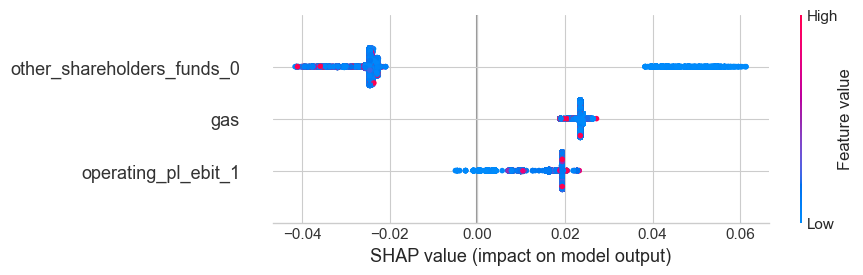

In [ ]:
# Cluster 10
shap.plots.beeswarm(shap_values[...,subset, 1])

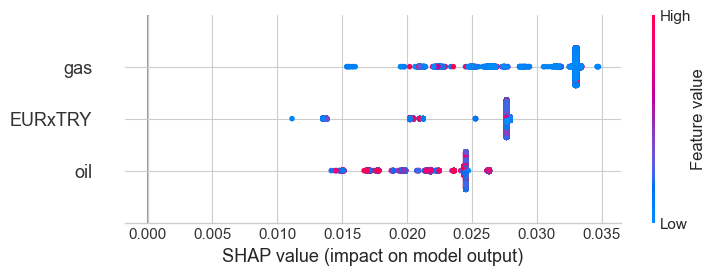

In [ ]:
# Cluster 9
shap.plots.beeswarm(shap_values[...,subset, 1])

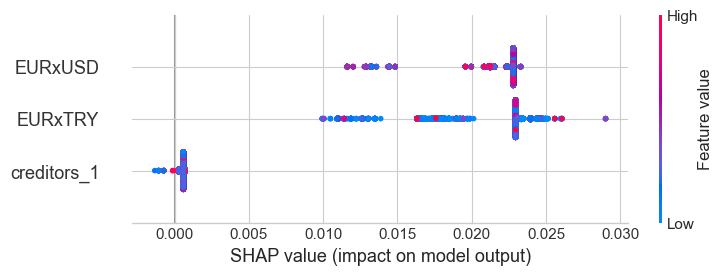

In [ ]:
# Cluster 8
shap.plots.beeswarm(shap_values[...,subset, 1])

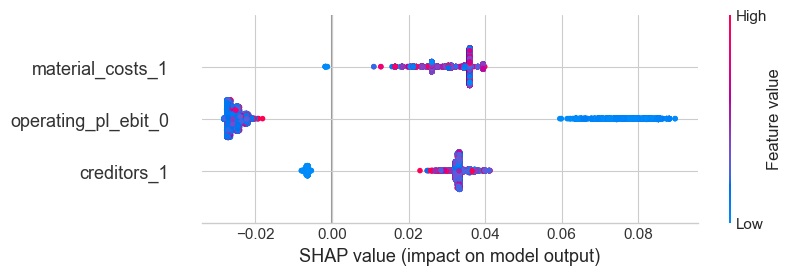

In [ ]:
# Cluster 7
shap.plots.beeswarm(shap_values[...,subset, 1])

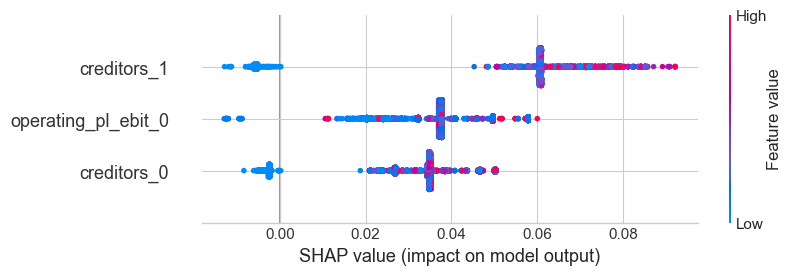

In [ ]:
# Cluster 6
shap.plots.beeswarm(shap_values[...,subset, 1])

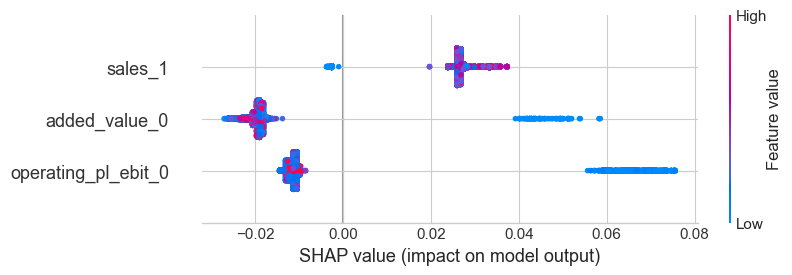

In [ ]:
# Cluster 5
shap.plots.beeswarm(shap_values[...,subset, 1])

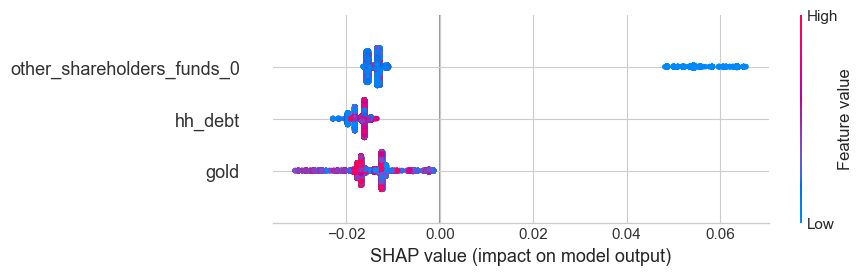

In [ ]:
# Cluster 4
shap.plots.beeswarm(shap_values[...,subset, 1])

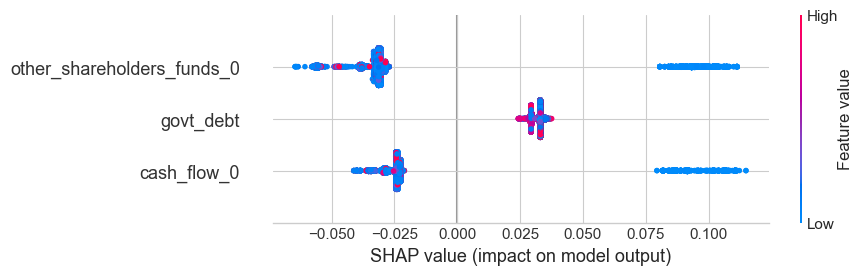

In [ ]:
# Cluster 3
shap.plots.beeswarm(shap_values[...,subset, 1])

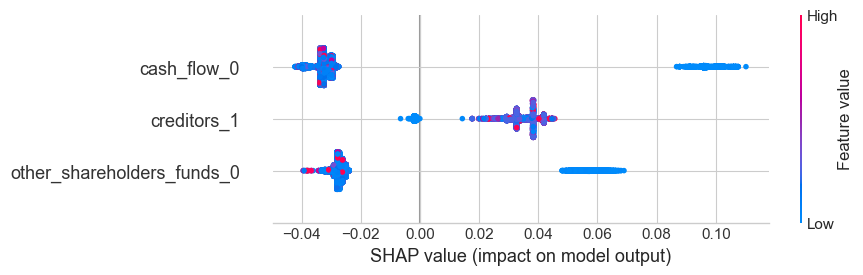

In [ ]:
# cluster 2 
shap.plots.beeswarm(shap_values[...,subset, 1])